In [ ]:
!pip install gpudb==7.2.0.0b0 pandas pyarrow typeguard langchain langchain_openai nemollm==0.3.5 colorlog "langchain-kinetica @ git+https://git@github.com/kineticadb/langchain-kinetica.git"

In [46]:
import gpudb
import json
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate
from langchain_kinetica import KineticaChatLLM, KineticaSqlOutputParser, SqlResponse

#db = gpudb.GPUdb(host='https://demo72.kinetica.com/_gpudb',
#                 username='gtc',
#                 password='Kinetica123!')

# create the Kinetica connection
kdbc = KineticaChatLLM._create_kdbc(host="https://demo72.kinetica.com/_gpudb", login="gtc", password="Kinetica123!")

# create the Kinetica LLM
kinetica_llm = KineticaChatLLM(kdbc=kdbc)

# Set the context to use
kinetica_ctx = 'nyse.nyse_vector_ctxt'

Connected to Kinetica: http://172.31.33.30:9191. (api=7.2.0.0b0, server=7.2.0.0)


In [47]:
# load the context from the database
ctx_messages = kinetica_llm.load_messages_from_context(kinetica_ctx)

# Add the input prompt. This is where input question will be substituted.
ctx_messages.append(("human", "{input}"))

# Create the prompt template.
prompt_template = ChatPromptTemplate.from_messages(ctx_messages)
prompt_template.pretty_print()

# create the chain. 
# note: The KineticaSqlOutputParser will execute the SQL statement and is optional.
chain = prompt_template | kinetica_llm | KineticaSqlOutputParser(kdbc=kdbc)

================================ System Message ================================

CREATE TABLE nyse.prices AS
(
   t DATETIME NOT NULL COMMENT 'timestamp',
   s VARCHAR (8, dict, shard_key) NOT NULL COMMENT 'stock symbol',
   type VARCHAR (4, dict) NOT NULL,
   ap REAL  COMMENT 'ask price',
   as INTEGER,
   bp REAL  COMMENT 'bid price',
   bs INTEGER  COMMENT 'bid size',
   lp REAL  COMMENT 'sale price',
   ls INTEGER  COMMENT 'sale size'
);
COMMENT ON TABLE nyse.prices IS 'Stock prices including ask, bid, and sale price and size';
-- When querying table nyse.prices the following rules apply:
-- * when I ask about stock prices, use the nyse.prices table
-- * when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day
-- * all stock symbols are in lower case
-- * when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day
-- * when I ask about any column, make sure there are no null

In [48]:
from IPython.display import display, HTML

# Here you must ask a question relevant to the LLM context provided in the prompt template.
response: SqlResponse = chain.invoke({"input": '''what stock has traded with the highest volume today?'''})
display(HTML(response.dataframe.to_html(index=False)))
    

s,total_volume
psq,370825


<Axes: xlabel='t'>

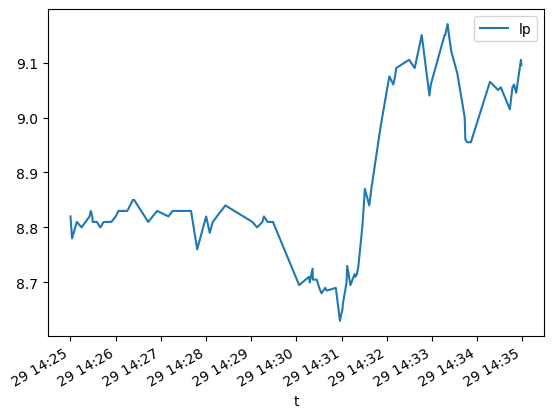

In [49]:
response: SqlResponse = chain.invoke({"input": '''find all sofi stock trades between 2024-01-29 14:25:00 and 2024-01-29 14:35:00 where the price is not null'''})
response.dataframe.plot.line(x='t', y='lp')

In [50]:
response: SqlResponse = chain.invoke({"input": '''find similar patterns to sofi at 2024-01-29 14:25:00.000'''})
display(HTML(response.dataframe.to_html(index=False)))

ts_bkt,symbol,d1
2024-01-22 15:45:00,qqq,-150224.312500
2024-01-19 14:45:00,qqq,-135271.500000
2024-01-22 17:05:00,qqq,-123674.156250
2024-01-22 16:00:00,qqq,-122803.632812
2024-01-22 15:30:00,qqq,-121132.281250


<Axes: xlabel='t'>

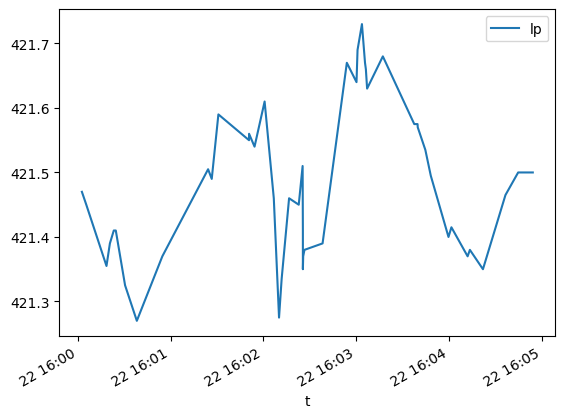

In [55]:
response: SqlResponse = chain.invoke({"input": '''find all qqq stock trades between 2024-01-22 16:00:00 and 2024-01-22 16:05:00 where the price is not null'''})
response.dataframe.plot.line(x='t', y='lp')